In [1]:
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import math
from functools import reduce
%matplotlib inline
np.random.seed(42)

In [2]:
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [3]:
X_train, Y_train, X_test, Y_test = load()

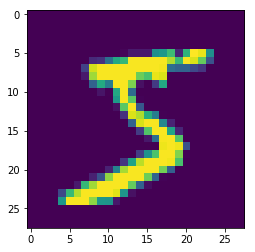

In [4]:
plt.imshow(X_train[0].reshape(28,28))

In [5]:
class FC:
    def __init__(self, in_channel, out_channel):
        self.W = {'val': np.random.standard_normal((in_channel,out_channel)), 'grad': 0}
        self.b = {'val': np.random.randn(out_channel), 'grad': 0}
        self.cache = None
    
    def forward(self, X):
        out = np.dot(X, self.W) + self.b
        self.cache = X
        return out
    
    def backward(self, dout):
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        self.update()
        return dX
    
    def update(self, lr=0.001):
        self.W['val'] -= lr*self.W['grad']
        self.b['val'] -= lr*self.b['grad']

In [48]:
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size,kernel_size,in_channels,out_channels)
        self.stride = stride
        self.cache = 0
        
        self.W = {'val': np.random.standard_normal((self.kernel_size)), 'grad': np.zeros(self.kernel_size)}
        self.b = {'val': np.random.standard_normal(out_channels), 'grad': np.zeros(out_channels)}
        
    def forward(self, x):
        (N,Cin,H,W) = x.shape
        self.input_shape = x.shape
        H_ = int((H - self.kernel_size[0]) / self.stride + 1)
        W_ = int((W - self.kernel_size[0]) / self.stride + 1)
        col_weights = self.W['val'].reshape([-1,self.out_channels])
        self.col_image = []
        conv_out = np.zeros((N,self.out_channels,H_,W_))
        for i in range(N):
            img_i = x[i]
            self.col_image_i = self.im2col(img_i,self.kernel_size[0],self.stride)
            print(self.col_image_i.shape)
            conv_out[i] = np.reshape(np.dot(self.col_image_i, col_weights) + self.b['val'],(H_,W_,-1)).transpose(2,0,1)
            self.col_image.append(self.col_image_i)
        self.col_image = np.array(self.col_image)
        return conv_out
    
    def backward(self, dout):
        (N,Cout,H_,W_) = dout.shape
        col_dout = dout.reshape((N,Cout,-1))
        
        for i in range(self.input_shape[0]):
            self.W['grad'] += np.dot(col_dout[i], self.col_image[i]).reshape(self.W['val'].shape)
        self.b['grad'] += np.sum(col_dout,axis=(0,2)).reshape(self.b['val'].shape)
        
        dout_pad = np.pad(dout, ((0, 0), (0, 0), (self.kernel_size[0] - 1, self.kernel_size[0] - 1), (self.kernel_size[0] - 1, self.kernel_size[0] - 1)), 'constant', constant_values=0)
        
        weight_flip = self.W['val'][:,:,::-1,::-1]
        weight_flip = np.swapaxes(weight_flip, 0, 1)
        weight_flip_col = weight_flip.reshape(self.in_channels, -1)
        
        next_dout =  np.zeros((N, self.in_channels, self.input_shape[2], self.input_shape[3]))
        for i in range(N):
            dout_pad_image_batch_i = dout_pad[i,:]
            dout_pad_image_batch_i_col = self.im2col(dout_pad_image_batch_i , self.kernel_size[0], self.stride)
            next_dout[i] = np.reshape(np.dot(weight_flip_col, np.transpose(dout_pad_image_batch_i_col)), (self.in_channels, self.input_shape[2], self.input_shape[3]))
        
        return next_dout
        
    def im2col(self, image, ksize, stride):
        # image is a 3d tensor([channel, height, width])
        image_col = []
        for i in range(0, image.shape[1] - ksize + 1, stride):
            for j in range(0, image.shape[2] - ksize + 1, stride):
                col = image[:,i:i + ksize, j:j + ksize].reshape([-1])
                image_col.append(col)
        image_col = np.array(image_col)
        return image_col

In [7]:
class MaxPool2d:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        self.mask = 0
    
    def forward(self, x):
        (N,Cin,H,W) = x.shape
        H_ = int(H/self.kernel_size)
        W_ = int(W/self.kernel_size)
        out = np.zeros((N, Cin, H_, W_))
        self.mask = np.zeros(x.shape)
        for n in range(N):
            for cin in range(Cin):
                for h in range(0, H, self.stride):
                    for w in range(0, W, self.stride):
                        out[n,cin,h//self.stride,w//self.stride] = np.max(x[n,cin,h:h + self.kernel_size, w:w + self.kernel_size])
                        i,j = np.unravel_index(np.argmax(x[n,cin,h:h + self.kernel_size, w:w + self.kernel_size]),(self.kernel_size,self.kernel_size))
                        self.mask[n,cin,i+h,j+w] = 1
        return out
    
    def backward(self,dout):
        return np.repeat(np.repeat(dout, self.stride, axis=2), self.stride, axis=3) * self.mask

In [24]:
class LogSoftmax():
    def __init__(self):
        self.cache = None
        self.loss = 0
        
    def forward(self, prediction):
        self.prediction = prediction
        exp_prediction = np.zeros(prediction.shape)
        self.softmax = np.zeros(prediction.shape)
        for n in range(prediction.shape[0]):
            prediction[n, :] -= np.max(prediction[n, :]) # 防止上溢出
            exp_prediction[n] = np.exp(prediction[n])
            self.softmax[n] = exp_prediction[n]/np.sum(exp_prediction[n])
        self.log_softmax = np.log(self.softmax)
        
        return self.log_softmax
    
    def backward(self):
        pass

In [25]:
class NLLLoss():
    def __init__(self):
        self.loss = 0
    
    def forward(self, pred, target):
        N = pred.shape[0]
        for n in range(N):
            label = target[n]
            self.loss += np.log(-pred[n,label])
        return self.loss / N
        
    def backward(self):
        pass

In [20]:
class CrossEntropyLoss():
    def __init__(self):
        pass
    
    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        logSoftmax = LogSoftmax()
        nllLoss = NLLLoss()
        prob = logSoftmax.forward(Y_pred)
        loss = nllLoss.forward(prob, Y_true)
        dout = prob.copy()
        dout[np.arange(N), Y_true] -= 1
        return loss, dout

In [11]:
class SGD():
    def __init__(self, params, lr):
        self.l = len(params)
        self.params = params
        self

In [49]:
batch = X_train[0:2].reshape(2,1,28,28)

In [50]:
conv2d = Conv2d(1,6,5)
out = conv2d.forward(batch)
out.shape

(576, 25)
(576, 25)


(2, 6, 24, 24)

In [51]:
real = out.copy() + 1

In [52]:
dout = conv2d.backward(real-out)

In [53]:
dout

array([[[[ -5.60940891, -10.83559184, -10.82332433, ...,  -0.57075499,
           -0.5830225 ,   0.97290732],
         [ -8.84154755, -18.74743301, -20.49830635, ...,  -1.93744294,
           -0.1865696 ,   0.78923514],
         [-12.66774302, -20.3079634 , -23.26653143, ...,   0.06372398,
            3.02229201,   0.48989108],
         ...,
         [ -0.13819793,   2.60949862,   1.72871981, ...,   5.86016799,
            6.7409468 ,  -1.06757788],
         [  3.68799755,   4.17002901,   4.49694489, ...,   3.85900107,
            3.5320852 ,  -0.76823382],
         [ -0.19715702,   0.70554064,   1.61050725, ...,   1.68101308,
            0.77604646,  -0.6356793 ]]],


       [[[ -5.60940891, -10.83559184, -10.82332433, ...,  -0.57075499,
           -0.5830225 ,   0.97290732],
         [ -8.84154755, -18.74743301, -20.49830635, ...,  -1.93744294,
           -0.1865696 ,   0.78923514],
         [-12.66774302, -20.3079634 , -23.26653143, ...,   0.06372398,
            3.02229201,   0.489

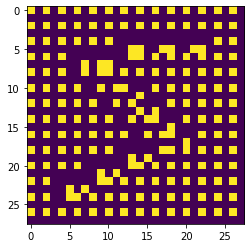

In [52]:
pool2d = MaxPool2d()
out = pool2d.forward(batch)
plt.imshow(pool2d.mask[0].reshape(28,28))

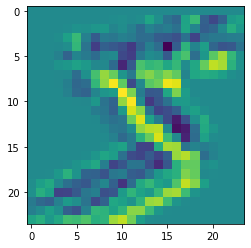

In [9]:
plt.imshow(out[0,0,:,:].reshape(24,24))